In [1]:
# Python program to implement Runge Kutta method
# A sample differential equation "dy / dx = (x - y)/2"
def dydx(x, y):
	return ((x - y)/2)

# Finds value of y for a given x using step size h
# and initial value y0 at x0.
def rungeKutta(x0, y0, x, h):
	# Count number of iterations using step size or
	# step height h
	n = (int)((x - x0)/h)
	# Iterate for number of iterations
	y = y0
	for i in range(1, n + 1):
		"Apply Runge Kutta Formulas to find next value of y"
		k1 = h * dydx(x0, y)
		k2 = h * dydx(x0 + 0.5 * h, y + 0.5 * k1)
		k3 = h * dydx(x0 + 0.5 * h, y + 0.5 * k2)
		k4 = h * dydx(x0 + h, y + k3)

		# Update next value of y
		y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)

		# Update next value of x
		x0 = x0 + h
	return y

# Driver method
x0 = 0
y = 1
x = 2
h = 0.2
print ('The value of y at x is:', rungeKutta(x0, y, x, h))

# This code is contributed by Prateek Bhindwar


The value of y at x is: 1.1036393232374955


Success, termination event occured.


(0.0, 38.793793793793796)

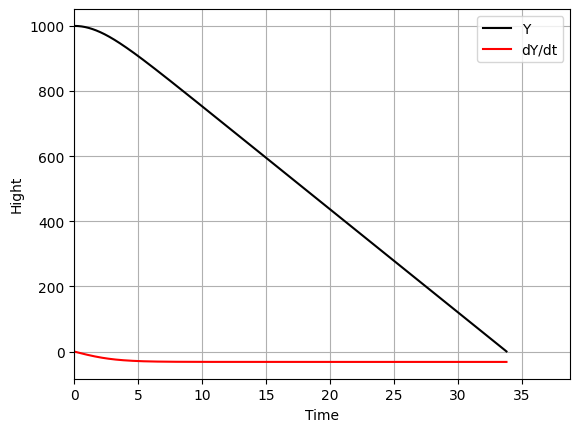

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

g = 10
k = 0.01

def para(t,Y):
    y1 = Y[0]
    y2 = Y[1]
    dy1_dt = y2
    dy2_dt = -g + k*y2**2
    return [dy1_dt,dy2_dt]

def hit_ground(t, Y): return Y[0]


import numpy as np
tend = 40
time = np.linspace(0,tend,1000)
tspan = (0, tend)

Y0 = [1000,0]

from scipy.integrate import solve_ivp
hit_ground.terminal = True
Y = solve_ivp(para,tspan,Y0,events=hit_ground,t_eval=time)

if Y.status == 1:
    print('Success, termination event occured.')
if Y.status == 0:
    print('Success, t end reached.')

plt.plot(Y.t,Y.y[0,:],'k-',label='Y')
plt.plot(Y.t,Y.y[1,:],'r-',label='dY/dt')
plt.xlabel('Time')
plt.ylabel('Hight')
plt.legend()
plt.grid()
plt.xlim(0,Y.t[-1]+5) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Success, termination event occured.
(457, 7)
          time        X_ECEF  Y_ECEF  Z_ECEF     Vx_ECEF  Vy_ECEF  Vz_ECEF
452  44.911364  6.378281e+06     0.0     0.0 -439.129462      0.0      0.0
453  45.011364  6.378237e+06     0.0     0.0 -440.109253      0.0      0.0
454  45.111364  6.378193e+06     0.0     0.0 -441.089058      0.0      0.0
455  45.211364  6.378149e+06     0.0     0.0 -442.068876      0.0      0.0
456  45.238374  6.378137e+06     0.0     0.0 -442.333522      0.0      0.0
<class 'pandas.core.frame.DataFrame'>
     time  X_ECEF  Y_ECEF  Z_ECEF  Vx_ECEF  Vy_ECEF  Vz_ECEF  lat  long  \
452   NaN     NaN     NaN     NaN      NaN      NaN      NaN  0.0   0.0   
453   NaN     NaN     NaN     NaN      NaN      NaN      NaN  0.0   0.0   
454   NaN     NaN     NaN     NaN      NaN      NaN      NaN  0.0   0.0   
455   NaN     NaN     NaN     NaN      NaN      NaN      NaN  0.0   0.0   
456   NaN     NaN     NaN     NaN      NaN      NaN      NaN  0.0   0.0   

            alt 

(0.0, 50.238373556416555)

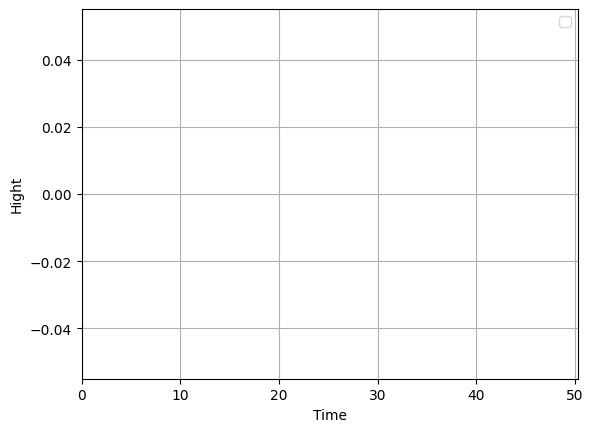

In [8]:
# change Python Path
from pathlib import Path
from typing import Callable
pkg_dir = Path().resolve().parents[0]
import sys
sys.path.insert(0,str(pkg_dir.absolute()))

import matplotlib.pyplot as plt
import pandas as pd


from firefly.geography.gravity import gravity
from firefly.geography.position import Position
import numpy as np

list_data =[
    "time",
    "X_ECEF",
    "Y_ECEF",
    "Z_ECEF",
    "Vx_ECEF",
    "Vy_ECEF",
    "Vz_ECEF",
]

earth_model = "SPHERICAL"

# support functions
def gravity4X(
        t:float,
        X: list[float]) -> list[float]:
    return gravity(Position(*X[0:3]),earth_model=earth_model)
    


def pfd(
        t:float,
        X:list[float]) -> list[float]:

    [x,y,z,vx,vy,vz] = X

    velocity = [vx, vy, vz]

    # Position Equation
    dx_dt = velocity
    

    dv_dt = gravity4X(t,X)

    return dx_dt + dv_dt

def hit_ground(t, X): 

    [x,y,z,_,_,_] = X

    [_,_,alt] = Position(x,y,z).as_LLA(earth_model=earth_model)
    
    return alt


# initi value
pos0 = Position.from_LLA(0.,0.,10000.)

X0 = [pos0.x,pos0.y,pos0.z,0.,0.,0.]

tend = 400
time = np.linspace(0,tend,10000)
tspan = (0, tend)

from scipy.integrate import solve_ivp, RK45
hit_ground.terminal = True
Y = solve_ivp(pfd,tspan,X0,events=[hit_ground],max_step=0.1,
              dense_output=True)

if Y.status == 1:
    print('Success, termination event occured.')
if Y.status == 0:
    print('Success, t end reached.')



df = pd.DataFrame(
    np.concatenate((Y.t[:, np.newaxis], Y.y.T), axis= 1),columns=list_data)

print(df.shape)

print(df.tail())

from typing import NamedTuple

class Information2Add(NamedTuple):
    fct: Callable
    columnsName: list[str]


# Add informations to dataframe

def run_loopy(df):
    lat,long,alt = [], [], []
    for _, row in df.iterrows():
        lat_n, long_n, alt_n = Position(*row[
            ["X_ECEF",
            "Y_ECEF",
            "Z_ECEF"]].tolist()
            ).as_LLA()
        lat.append(lat_n)
        long.append(long_n)
        alt.append(alt_n)
    return pd.DataFrame({'lat': lat,
                      'long': long,
                      'alt': alt})

new = run_loopy(df)
print(type(new))

df = pd.concat([df, new])
print(df.tail())



# def LLA4X(
#         row: pd.Series):
#     [lat,long,alt ]= Position(*row[
#         ["X_ECEF",
#         "Y_ECEF",
#         "Z_ECEF"]].tolist()
#         ).as_LLA()
#     return [lat, long, alt]

# df[["lat","long","alt"]] = df.apply(LLA4X ,axis=1,extend)

# # tt = Information2Add(
# #                    fct = LLA4X,
# #                    columnsName=["Lat","Long","Alt"]
# #                )
# # print(tt)
# # apply_function(df=df,
# #                newInfo=tt)

# print(df)
    

# #df["time"] = pd.to_timedelta(df["time"],unit="S")

# ts = df.set_index('time')

# print(ts)

plt.plot(df["time"],df["alt"])
plt.xlabel('Time')
plt.ylabel('Hight')
plt.legend()
plt.grid()
plt.xlim(0,Y.t[-1]+5) 

In [11]:
import pandas as pd

# Create a sample DataFrame
data = {'A': [1, 2, 3, 4],
        'B': [5, 6, 7, 8]}

df = pd.DataFrame(data)

# Define a function that takes two arguments and returns their sum
def add_columns(x, y):
    return x + y

# Use the apply method to create a new column 'C' based on the function
df['C'] = df.apply(lambda row: add_columns(row['A'], row['B']), axis=1)

# Print the updated DataFrame
print(df)

   A  B   C
0  1  5   6
1  2  6   8
2  3  7  10
3  4  8  12


In [14]:
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({'A': [1, 2, 3, 4], 'B': [5, 6, 7, 8]})

# Define a function to calculate the new columns
def calculate_new_columns(a, b):
  return a + b, a + b * 2

# Create multiple new columns using the assign() method
df = df.assign(new_column_1=lambda x: calculate_new_columns(x['A'], x['B'])[0],
                new_column_2=lambda x: calculate_new_columns(x['A'], x['B'])[1])

# Print the DataFrame
print(df)

   A  B  new_column_1  new_column_2
0  1  5             6            11
1  2  6             8            14
2  3  7            10            17
3  4  8            12            20


In [22]:
import pandas as pd
import numpy as np
import locale
import random, string

N = 10000
np.random.seed(0)
rand_name_lst=[''.join(random.choices(string.ascii_uppercase + string.digits, k=5)) \
                            for i in range(N)]
rand_int_lst = np.random.randint(912131,18293293,size=N)
df = pd.DataFrame({'name': rand_name_lst , 'size': rand_int_lst})

df.sample(5)


def convert_size(x):
    kb = round((x / 1024.0),2)
    mb = round((x / (1024.0 ** 2)),2)
    gb = round((x / (1024 **3)),2)

    return pd.Series([kb, mb, gb])


#df[['size_kb','size_mb','size_gb']]=df['size'].apply(convert_size)


df['size_kb'],df['size_mb'],df['size_gb']=convert_size(df['size'])

print(df.tail())


       name      size   size_kb  size_mb  size_gb
9995  F17T0   3981810   3888.49     3.80     0.00
9996  DL0MW   2686217   2623.26     2.56     0.00
9997  JCNCR  16210932  15830.99    15.46     0.02
9998  PBQM7   9789833   9560.38     9.34     0.01
9999  OTJBZ   2467945   2410.10     2.35     0.00


In [91]:
# change Python Path
from pathlib import Path
from typing import Any, Callable, Dict
pkg_dir = Path().resolve().parents[0]
import sys
sys.path.insert(0,str(pkg_dir.absolute()))

import matplotlib.pyplot as plt
import pandas as pd


from firefly.geography.gravity import gravity
from firefly.geography.position import Position
import numpy as np

list_data =[
    "time",
    "X_ECEF",
    "Y_ECEF",
    "Z_ECEF",
    "Vx_ECEF",
    "Vy_ECEF",
    "Vz_ECEF",
]

earth_model = "SPHERICAL"

# support functions
def gravity4X(
        t:float,
        X: list[float]) -> list[float]:
    return gravity(Position(*X[0:3]),earth_model=earth_model)
    


def pfd(
        t:float,
        X:list[float]) -> list[float]:

    [x,y,z,vx,vy,vz] = X

    velocity = [vx, vy, vz]

    # Position Equation
    dx_dt = velocity
    

    dv_dt = gravity4X(t,X)

    return dx_dt + dv_dt # concat vector

def hit_ground(t, X): 

    [x,y,z,_,_,_] = X

    [_,_,alt] = Position(x,y,z).as_LLA(earth_model=earth_model)
    
    return alt


# initi value
pos0 = Position.from_LLA(0.,0.,1000000.)

X0 = [pos0.x,pos0.y,pos0.z,0.,0.,0.]

tend = 40000
time = np.linspace(0,tend,10000)
tspan = (0, tend)

from scipy.integrate import solve_ivp, RK45
hit_ground.terminal = True
Y = solve_ivp(pfd,tspan,X0,events=[hit_ground],max_step=0.1,
              dense_output=True)

if Y.status == 1:
    print('Success, termination event occured.')
if Y.status == 0:
    print('Success, t end reached.')



df = pd.DataFrame(
    np.concatenate((Y.t[:, np.newaxis], Y.y.T), axis= 1),columns=list_data)

# print(df.shape)

# print(df.tail())


# Add informations to dataframe

def calculate_position(t,X):
    lat_n, long_n, alt_n = Position(*X[0:3]).as_LLA()
    
    return {'lat': lat_n,
            'long': long_n,
            'alt': alt_n}

def calculate_position2(t,X):
    lat_n, long_n, alt_n = Position(*X[0:3]).as_LLA()
    
    return {'lat2': lat_n,
            'long2': long_n,
            'alt2': alt_n}

def add_parameters(
        df:pd.DataFrame,
        funs:list[Callable[[float, list[float]], Dict[str, Any]]]
        ) -> pd.DataFrame:
    
    tt = []
    
    for index, row in df.iterrows():

        # initiate dict
        new_row_as_dict = {}

        #create X
        X = row[list_data[1:]]

        # create t
        t = row["time"]
        for fun in funs:

            dict_to_add = fun(t,X)
            if dict_to_add.keys() & new_row_as_dict.keys() == set():
                new_row_as_dict.update(dict_to_add)
            else:
                common_keys = list(dict_to_add.keys() & new_row_as_dict.keys())
                msg = [
                    f"The following keys are used at least twice: {common_keys}"
                ]
                raise KeyError(msg)
        
        tt.append(new_row_as_dict)

    new_df = pd.DataFrame.from_dict(tt) # type: ignore
    return pd.concat([df,new_df],axis=1)


df2 = add_parameters(df,funs=[calculate_position,calculate_position2]) 

# print(df2.tail())

# print(Y)





Success, termination event occured.
